# Build and Deploy an in-Db2 Machine Learning Model with Db2 v11.5

In this workshop we will use Db2's native machine learning algorithms to build a customer segmentation model using the K-Means Clustering algorithms. Our sample dataset tells us about customers at a bank and contains information such as their age, employment status, marital status, education level, and bank balance. We will use this data and the K-Means algorithm to segment these customers, allowing the buisness to more effectively target specific groups in their customer base.

**Prerequisites**: If you are unfamiliar with the Jupyter Notebook environment, it is recommended to have gone through the [An Introduction to Jupyter Notebooks](./An_Introduction_to_Jupyter_Notebooks.ipynb) lab first

## Imports and Connection to Db2

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

First load the Db2 magic functions and make a connection to our Db2 database.

In [2]:
%run db2.ipynb

Db2 Extensions Loaded.


In [3]:
%run connectiondb2ml-banking.ipynb

Connection successful.


In [4]:
%sql option maxrows -1

We will run the following notebook to make sure our working schema is clean.

In [5]:
%run Db2MLTutorial1CleanUp.ipynb

Db2 Extensions Loaded.
Connection successful.


Command completed.
Schema is already clean.
Clean Up Successful.


## Read in Data

We will first make a copy of our training and test data to a new schema `CLUSTERING`. This will allow us to modify the data without affecting the underlying raw data

In [6]:
%%sql
CREATE TABLE CLUSTERING.TRAIN AS (SELECT * FROM BANK.TRAIN) WITH DATA

Command completed.


In [7]:
%%sql
CREATE TABLE CLUSTERING.TEST AS (SELECT * FROM BANK.TEST) WITH DATA

Command completed.


Let's take a look at the first 10 rows of our training data

In [8]:
%%sql
SELECT * FROM CLUSTERING.TRAIN ORDER BY ID FETCH FIRST 10 ROWS ONLY 

,ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,SUBSCRIBED
0,1,30.0,unemployed,married,primary,no,1787.0,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,2,NaN,services,married,secondary,no,4789.0,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,3,35.0,management,single,tertiary,no,1350.0,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,4,30.0,management,married,tertiary,no,1476.0,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,5,59.0,blue-collar,married,secondary,no,0.0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,6,NaN,management,single,tertiary,no,747.0,no,no,cellular,23,feb,141,2,176,3,failure,no
6,7,36.0,self-employed,married,tertiary,no,307.0,yes,no,cellular,14,may,341,1,330,2,other,no
7,8,39.0,technician,married,secondary,no,147.0,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,9,41.0,entrepreneur,married,tertiary,no,221.0,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,10,NaN,services,married,primary,no,-88.0,yes,yes,cellular,17,apr,313,1,147,2,failure,no


## Data Exploration

Before we begin to modify our data, we must first understand the underlying distributions. We will look at the number of missing values, cardinality (number of unique values), and variance (this tells us what range of values the feature takes). We will use the `COLUMN_PROPERTIES` stored procedure to collect summary statistics about the features in our dataset.

Input Parameters:
- intable: Name of the input table
- outtable: The output table that contains the column properties data
- incolumn: The columns of the input table that have specific properties
- withstatistics: A flag that indicates whether statistical properties of the columns should be collected

[IDAX.COLUMN_PROPERTIES Documentation](https://www.ibm.com/docs/en/db2/11.5?topic=exploration-idaxcolumn-properties-create-column-properties-table)

In [9]:
%%sql
CALL IDAX.COLUMN_PROPERTIES('intable=CLUSTERING.TRAIN,outtable=CLUSTERING.COLPROP,incolumn=ID:id,
                            withstatistics=true')

Command completed.


In [10]:
%%sql
SELECT * FROM CLUSTERING.COLPROP ORDER BY COLNO

,COLNO,NAME,SQLTYPE,LENGTH,SCALE,TYPE,ROLE,WEIGHT,CARDINALITY,MINIMUM,MAXIMUM,MEAN,VARIANCE,NUMVALID,NUMINVALID,NUMMISSING
0,0,ID,INTEGER,4,0,cont,id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AGE,INTEGER,4,0,cont,input,1.0,65.0,19.0,87.0,41.234172,1.104071e+02,3617.0,0.0,904.0
2,2,JOB,VARCHAR,13,0,nom,input,1.0,12.0,NaN,NaN,NaN,NaN,4521.0,0.0,0.0
3,3,MARITAL,VARCHAR,8,0,nom,input,1.0,3.0,NaN,NaN,NaN,NaN,4521.0,0.0,0.0
4,4,EDUCATION,VARCHAR,9,0,nom,input,1.0,4.0,NaN,NaN,NaN,NaN,4521.0,0.0,0.0
5,5,DEFAULT,VARCHAR,3,0,nom,input,1.0,2.0,NaN,NaN,NaN,NaN,4521.0,0.0,0.0
6,6,BALANCE,DOUBLE,8,0,cont,input,1.0,2353.0,-3313.0,71188.0,1422.657819,9.055918e+06,4521.0,0.0,0.0
7,7,HOUSING,VARCHAR,3,0,nom,input,1.0,2.0,NaN,NaN,NaN,NaN,4521.0,0.0,0.0
8,8,LOAN,VARCHAR,3,0,nom,input,1.0,2.0,NaN,NaN,NaN,NaN,4521.0,0.0,0.0
9,9,CONTACT,VARCHAR,9,0,nom,input,1.0,3.0,NaN,NaN,NaN,NaN,4521.0,0.0,0.0


### Missing Values

Let's now look at the number of missing values using the column properties table we just created. We can use the query below to inquire about the number of missing values and the total percentage of missing values in each feature.

In [11]:
%%sql
SELECT COLNO, NAME, TYPE, NUMMISSING, NUMMISSING + NUMINVALID + NUMVALID as NUMBER_OF_VALUES, 
ROUND(DEC(NUMMISSING,10,2)/(DEC(NUMMISSING, 10,2)+DEC(NUMINVALID, 10,2)+DEC(NUMVALID, 10,2))*100,2) 
AS PERCENT_NULL
FROM CLUSTERING.COLPROP WHERE NUMMISSING > 0 ORDER BY PERCENT_NULL DESC

,COLNO,NAME,TYPE,NUMMISSING,NUMBER_OF_VALUES,PERCENT_NULL
0,1,AGE,cont,904,4521,20.0


We can see that the `AGE` feature has some missing values that require imputation.

#### Hands-On Exercise 1

Most machine learning algorithms prefer for the categorical features (i.e., columns) in the dataset to not contain too many unique values. Additionally, they prefer for numerical features and to be similarly scaled. Therefore we want to ensure that both the cardinality of our categorical features (i.e., number of unique values) and the maximum range of our numerical features remain low.

1. **Using the column properties table we have just created identify any categorical columns with high cardinality**
2. **Using the column properties table identify any continuous columns with the widest ranges of values**

In [12]:
### YOUR CODE HERE ###

**Solution:**

In [13]:
%%sql
SELECT COLNO, NAME, CARDINALITY
FROM CLUSTERING.COLPROP WHERE TYPE = 'nom' ORDER BY CARDINALITY DESC

,COLNO,NAME,CARDINALITY
0,11,MONTH,12
1,2,JOB,12
2,4,EDUCATION,4
3,16,POUTCOME,4
4,3,MARITAL,3
5,9,CONTACT,3
6,17,SUBSCRIBED,2
7,8,LOAN,2
8,5,DEFAULT,2
9,7,HOUSING,2


In [14]:
%%sql
SELECT COLNO, NAME, MINIMUM, MAXIMUM, MAXIMUM-MINIMUM AS RANGE
FROM CLUSTERING.COLPROP WHERE TYPE = 'cont' ORDER BY RANGE DESC

,COLNO,NAME,MINIMUM,MAXIMUM,RANGE
0,0,ID,NaN,NaN,NaN
1,6,BALANCE,-3313.0,71188.0,74501.0
2,12,DURATION,4.0,3025.0,3021.0
3,14,PDAYS,-1.0,871.0,872.0
4,1,AGE,19.0,87.0,68.0
5,13,CAMPAIGN,1.0,50.0,49.0
6,10,DAY,1.0,31.0,30.0
7,15,PREVIOUS,0.0,25.0,25.0


## Data Transformation

We are now ready to perform some data transformations on our training data. The transformations will be missing value imputation and standardization

### Missing Value Imputation

Most machine learning algorithms cannot work with missing values. We first use the `IMPUTE_DATA` stored procedure to impute (i.e., replace) missing values in the `AGE` feature in the training data using the mean value of the column.

Input Parameters:
- intable: Name of the input table
- method: The method of data imputation.
- incolumn: The columns of the input table where the missing values must be replaced
- withstatistics: A flag that indicates whether statistical properties of the columns should be collected

[IDAX.IMPUTE_DATA Documentation](https://www.ibm.com/docs/en/db2/11.5?topic=transformation-idaximpute-data-impute-missing-data)

In [15]:
%%sql
CALL IDAX.IMPUTE_DATA('intable=CLUSTERING.TRAIN, method=mean,incolumn=AGE')

Command completed.


Next, we perform the same imputation on the testing data, ensuring that we are imputing the missing values with the mean value in the *training* data.

In [16]:
%%sql
UPDATE CLUSTERING.TEST
SET AGE = (SELECT MEAN FROM CLUSTERING.COLPROP WHERE NAME = 'AGE')
WHERE AGE IS NULL

Command completed.


### Standardization

Most machine learning algorithms do not perform well when the numerical attributes in the data have very different scales (i.e., large range of possible values). We will use the `STD_NORM` stored procedure to standardize the feature `BALANCE` as it takes on a large range of values. A standardized value S is equal to (x-mean)/stddev, where x is the input value, mean is the mean value of the column, and stddev is the standard deviation of the column. The standardized values range from minus infinity to plus infinity.

Input Parameters:
- intable: Name of the input table
- id: The column of the input table that identifies a unique instance ID
- incolumn: The columns of the input table that are to be considered. Flags: L=leave unchanged, S=Standardize
- outtable: The output table that contains the modified data

[IDAX.STD_NORM Documentation](https://www.ibm.com/docs/en/db2/11.5?topic=transformation-idaxstd-norm-standardize-normalize-columns-input-table)


In [17]:
%%sql
CALL IDAX.STD_NORM('intable=CLUSTERING.TRAIN, id=ID, outtable=CLUSTERING.TRAIN_CLEAN,
                   incolumn=AGE:L;JOB:L;MARITAL:L;EDUCATION:L;DEFAULT:L;BALANCE:S;
                   HOUSING:L;LOAN:L;CONTACT:L;DAY:L;MONTH:L;DURATION:L;CAMPAIGN:L;PDAYS:L;
                   PREVIOUS:L;POUTCOME:L;SUBSCRIBED:L')

Command completed.


Next, we perform the same standardization on the testing data, ensuring that we are using the mean and standard deviation in the *training* data. We will also rename the column so that it is consistent with the new column name in the training data.

In [18]:
%%sql
ALTER TABLE CLUSTERING.TEST ADD STD_BALANCE DOUBLE;

UPDATE CLUSTERING.TEST
SET STD_BALANCE = (CAST(BALANCE AS FLOAT)-(SELECT MEAN FROM CLUSTERING.COLPROP WHERE NAME ='BALANCE'))/
(SELECT SQRT(VARIANCE) FROM CLUSTERING.COLPROP WHERE NAME ='BALANCE');

CREATE TABLE CLUSTERING.TEST_CLEAN AS (SELECT ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,STD_BALANCE,HOUSING,LOAN,
                                       CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,SUBSCRIBED 
                                       FROM CLUSTERING.TEST) WITH DATA

Command completed.


## Model Training

Now that we have cleaned versions of our training and test data, we are ready to being model training. We will use a K-means clustering model. The objective of K-means is simple: group similar data points together and discover underlying patterns.The K-means algorithm identifies k number of centroids (i.e., cluster centers), and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.

![Kmeans](media/kmeans.png)

**Figure 1:** This figure depicts an example of an idea clustering scenario. The different coloured points represent different clusters, while the large black dots represent the cluster centers (centroids).

We will train our model using the `KMEANS` stored procedure with default parameter values and k=3.

Input Parameters:
- model: The name of the clustering model that is to be built
- intable: The name of the input table
- id: The column of the input table that identifies a unique instance ID
- outtable: The name of the output table where the clusters are assigned to each input table record
- randseed: The random seed for the generator
- k: The number of clusters to build


[IDAX.KMEANS Documentation](https://www.ibm.com/docs/en/db2/11.5?topic=functions-idaxkmeans-build-k-means-clustering-model)

In [19]:
%%sql
CALL IDAX.KMEANS('model=CLUSTERING.KMEANS_3,intable=CLUSTERING.TRAIN_CLEAN,id=ID,outtable=CLUSTERING.KMEANS_3_OUT,
                 randseed=42,k=3')

Command completed.


We can query the model tables to get more information about the model we have just trained

In [20]:
%%sql
SELECT * FROM CLUSTERING.KMEANS_3_MODEL;

,MODELCLASS,COMPARISONTYPE,COMPARISONMEASURE,NUMCLUSTERS
0,center-based,distance,euclidean,3


The cluster table tells us about the clusters the model has created. Some features of note:
- **SIZE**: Number of data records in the cluster
- **RELSIZE**: Relative size of the cluster, that is, SIZE/Total number of records
- **WITHINSS**: A measure of the cluster homogeneity, that is, the sum of squared distances between records of the cluster and the cluster center.

In [21]:
%%sql
SELECT * FROM CLUSTERING.KMEANS_3_CLUSTERS ORDER BY CLUSTERID;

,CLUSTERID,NAME,DESCRIPTION,SIZE,RELSIZE,WITHINSS
0,1,1,None,518,0.114576,1.245241e+07
1,2,2,None,703,0.155497,7.681004e+07
2,3,3,None,3300,0.729927,3.844937e+07


### Model Tuning

We now need to determine the optimal value for k (number of clusters) in our model. A value of k that is too small will underfit our training data and will not be able to make useful predictions. A value of k that is too large will overfit our training data and will not be able to generalize well to new data. We will train models for k=3 to k=11 and then plot the mean sum of squared distances vs. k to determine the optimal value of k

In [22]:
%%time
%%sql
CALL IDAX.KMEANS('model=CLUSTERING.KMEANS_4,intable=CLUSTERING.TRAIN_CLEAN,id=ID,outtable=CLUSTERING.KMEANS_4_OUT,
randseed=42,k=4,distance=euclidean');
CALL IDAX.KMEANS('model=CLUSTERING.KMEANS_5,intable=CLUSTERING.TRAIN_CLEAN,id=ID,outtable=CLUSTERING.KMEANS_5_OUT,
randseed=42,k=5,distance=euclidean');
CALL IDAX.KMEANS('model=CLUSTERING.KMEANS_6,intable=CLUSTERING.TRAIN_CLEAN,id=ID,outtable=CLUSTERING.KMEANS_6_OUT,
randseed=42,k=6,distance=euclidean');
CALL IDAX.KMEANS('model=CLUSTERING.KMEANS_7,intable=CLUSTERING.TRAIN_CLEAN,id=ID,outtable=CLUSTERING.KMEANS_7_OUT,
randseed=42,k=7,distance=euclidean');
CALL IDAX.KMEANS('model=CLUSTERING.KMEANS_8,intable=CLUSTERING.TRAIN_CLEAN,id=ID,outtable=CLUSTERING.KMEANS_8_OUT,
randseed=42,k=8,distance=euclidean');
CALL IDAX.KMEANS('model=CLUSTERING.KMEANS_9,intable=CLUSTERING.TRAIN_CLEAN,id=ID,outtable=CLUSTERING.KMEANS_9_OUT,
randseed=42,k=9,distance=euclidean');
CALL IDAX.KMEANS('model=CLUSTERING.KMEANS_10,intable=CLUSTERING.TRAIN_CLEAN,id=ID,outtable=CLUSTERING.KMEANS_10_OUT,
randseed=42,k=10,distance=euclidean');
CALL IDAX.KMEANS('model=CLUSTERING.KMEANS_11,intable=CLUSTERING.TRAIN_CLEAN,id=ID,outtable=CLUSTERING.KMEANS_11_OUT,
randseed=42,k=11,distance=euclidean');


Command completed.
CPU times: user 7.83 ms, sys: 405 µs, total: 8.24 ms
Wall time: 39.9 s


In [23]:
# Collect the mean sum of squared distances for each model k=3 to k=11
ss_list = []

for k in range(3,12):
    table_name = "CLUSTERING.KMEANS_"+str(k)+"_CLUSTERS"
    # Select the mean sum of squared distances and append to a list for later plotting
    query = %sql SELECT AVG(WITHINSS) as MEAN_SS FROM {table_name}
    df = pd.DataFrame(query)
    value = df.iloc[0]['MEAN_SS']
    ss_list.append(value)

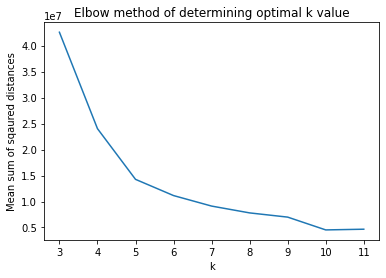

In [24]:
# Plot mean sum of squared distances vs. k
k=range(3,12)
plt.plot(k,ss_list);
plt.xlabel('k')
plt.ylabel('Mean sum of sqaured distances')
plt.title('Elbow method of determining optimal k value');

To select the optimal k value, we look at the "elbow point" in the graph - in our case we will select k=6.

## Make Predictions

With our final model selected, we can now apply this model to the test data using the `PREDICT_KMEANS` stored procedure and assign each record to a cluster.

Input Parameters:
- model: The name of the clustering model
- intable: The name of the input table
- id: The column of the input table that identifies a unique instance ID
- outtable: The name of the output table where the assigned clusters are stored


[IDAX.PREDICT_KMEANS Documentation](https://www.ibm.com/docs/en/db2/11.5?topic=functions-idaxpredict-kmeans-apply-k-means-clustering-model)

In [25]:
%%sql
CALL IDAX.PREDICT_KMEANS('model=CLUSTERING.KMEANS_6,intable=CLUSTERING.TEST_CLEAN,
                         outtable=CLUSTERING.PREDICTIONS,id=ID')

Command completed.


We can query the `CLUSTERING.PREDICTIONS` table to look at our model's predictions.

The table contains the following features:
- ID: The unique row identifier
- CLUSTER_ID: The cluster the row is mapped to
- DISTANCE: The distance between the input data point and the center of its assigned cluster.

In [26]:
%%sql
SELECT * FROM CLUSTERING.PREDICTIONS ORDER BY ID FETCH FIRST 10 ROWS ONLY 

,ID,CLUSTER_ID,DISTANCE
0,1,6,38.046444
1,4,4,35.495013
2,7,1,167.520540
3,11,4,44.904752
4,13,4,99.378080
5,16,4,43.045305
6,17,4,22.823244
7,24,6,14.999262
8,34,2,69.518233
9,37,6,41.196664


#### Hands-On Exercise 2

Return to the output of the `CLUSTERS` model table for the k=3 model (cell 17). Note that one of the clusters contains a large proportion of all the data points.

**Using the CLUSTERS model tables for our final model (k=6), print the summary of the clusters. What does this say about our choice of k?**

In [27]:
### YOUR CODE HERE ###

**Solution:**

In [28]:
%%sql
SELECT * FROM CLUSTERING.KMEANS_6_CLUSTERS ORDER BY CLUSTERID;

,CLUSTERID,NAME,DESCRIPTION,SIZE,RELSIZE,WITHINSS
0,1,1,None,458,0.101305,9.574983e+06
1,2,2,None,286,0.063260,3.583048e+07
2,3,3,None,807,0.178500,1.488889e+07
3,4,4,None,1230,0.272064,4.026643e+06
4,5,5,None,572,0.126521,9.385417e+05
5,6,6,None,1168,0.258350,1.594545e+06


## Analyze the Results

We can query the `KMEANS_6_OUT` table to find our typical customer for each cluster. The typical customer is the customer most representative of their group, and is therefore closest to the center of their respective cluster.

In [29]:
# Find the customers in the training set who are closest to their respective clusters
query = %sql SELECT * FROM CLUSTERING.KMEANS_6_OUT
df = pd.DataFrame(query)
df_arch = df.loc[df.groupby('CLUSTER_ID')['DISTANCE'].idxmin()]

# Add their ID's to a list - for use in following query
arch_ids = ', '.join([str(val) for val in df_arch['ID'].values])
df_arch.head(6)

,ID,CLUSTER_ID,DISTANCE
128,129,1,13.156168
4159,2034,2,38.548994
2510,2472,3,26.580996
1885,3895,4,7.546669
2824,2786,5,7.160607
1275,3285,6,5.112501


We can now use this list of IDs to map back to our training data and get more information about these customers.

In [30]:
%sql SELECT * FROM CLUSTERING.TRAIN_CLEAN WHERE ID IN ({arch_ids})

,ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,STD_BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,SUBSCRIBED
0,2472,22,student,single,secondary,no,0.353977,no,no,cellular,8,nov,449,2,38,10,other,yes
1,2786,41,technician,married,secondary,no,-0.172997,no,no,unknown,16,jun,35,6,-1,0,unknown,no
2,3285,41,admin.,married,secondary,no,-0.350759,no,no,telephone,16,nov,107,2,-1,0,unknown,no
3,3895,41,management,single,tertiary,no,-0.472701,yes,no,cellular,17,nov,213,2,-1,0,unknown,no
4,129,32,blue-collar,single,secondary,no,-0.396944,no,no,telephone,5,feb,176,1,288,3,failure,no
5,2034,41,blue-collar,divorced,primary,no,-0.252076,no,yes,cellular,15,jul,955,5,-1,0,unknown,yes


#### Hands-On Exercise 3

Suppose we chose a larger k value for our model, say k = 11.

**Who are the typical customers for a k=11 model? Do they differ from those in the k=6 model?**

In [31]:
### YOUR CODE HERE ###

**Solution**:

In [32]:
query = %sql SELECT * FROM CLUSTERING.KMEANS_11_OUT
df = pd.DataFrame(query)
df_arch = df.loc[df.groupby('CLUSTER_ID')['DISTANCE'].idxmin()]

# Add their ID's to a list - for use in following query
arch_ids = ', '.join([str(val) for val in df_arch['ID'].values])
df_arch.head(11)

,ID,CLUSTER_ID,DISTANCE
1586,1030,1,23.430567
1716,1160,2,14.081793
911,3891,3,27.835293
418,3398,4,25.989128
2189,2657,5,13.614171
3562,2542,6,3.882948
3041,12,7,7.692731
3073,44,8,5.213380
1143,587,9,12.597036
82,3062,10,3.138265


In [33]:
%sql SELECT * FROM CLUSTERING.TRAIN_CLEAN WHERE ID IN ({arch_ids})

,ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,STD_BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,SUBSCRIBED
0,1030,41,technician,married,secondary,no,-0.384318,yes,no,cellular,19,aug,168,2,-1,0,unknown,no
1,1160,31,management,single,tertiary,no,-0.452100,yes,no,cellular,18,may,175,1,293,5,failure,no
2,1483,39,blue-collar,married,secondary,no,-0.472701,yes,no,cellular,7,may,502,1,7,2,failure,no
3,2542,47,self-employed,married,unknown,no,-0.468049,yes,no,cellular,15,may,142,1,-1,0,unknown,no
4,3891,31,services,divorced,primary,no,-0.320191,yes,no,cellular,7,may,623,1,293,1,success,yes
5,12,43,admin.,married,secondary,no,-0.384982,yes,no,cellular,17,apr,113,2,-1,0,unknown,no
6,44,41,technician,married,tertiary,no,-0.341123,yes,no,cellular,13,may,205,3,-1,0,unknown,no
7,587,41,self-employed,single,secondary,no,-0.300587,yes,no,cellular,18,may,34,7,-1,0,unknown,no
8,2657,41,technician,married,secondary,no,-0.236127,yes,no,cellular,18,nov,291,2,-1,0,unknown,no
9,3062,41,retired,married,secondary,no,-0.416880,no,no,cellular,19,aug,79,2,-1,0,unknown,no


## Clean Up

With our analysis done, we are ready to clean up our working schema. We will use the `IDAX.DROP_MODEL` stored procedure to delete the models and their associated model tables. Then we can use normal `DROP TABLE` statements to delete the rest of the tables in our schema. These cleanup steps are contained in the `Db2MLTutorial1CleanUp.ipynb` notebook.

In [39]:
%run Db2MLTutorial1CleanUp.ipynb

Db2 Extensions Loaded.
Connection successful.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Clean Up Successful.


## Resources

[Video: K-Means Clustering with IBM Db2](https://video.ibm.com/recorded/128337524)\
[Video: Decision Tree Classifier with IBM Db2](https://video.ibm.com/recorded/127807200)\
[Video: Linear Regression with IBM Db2](https://video.ibm.com/recorded/127807190)\
[Video: Integrating a Db2 Native Model with a Business Application](https://video.ibm.com/recorded/127807226)